# Image Data Processing with PyTorch

## Data Loading and Exploration


In [12]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import ImageFolder
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm 

In [2]:
# Define the path to the dataset
data_dir = 'C:/Trina/TRU/Courses/Fall-24/ADSC_3920/img_aug/datasets/intel_image_data'

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
dataset = ImageFolder(root=os.path.join(data_dir, 'seg_train/seg_train'), transform=transform)

In [3]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Display the number of images in the dataset
print(f"Number of training images: {train_size}")
print(f"Number of validation images: {val_size}")

Number of training images: 11227
Number of validation images: 2807


In [4]:
# Display some sample images from the dataset
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

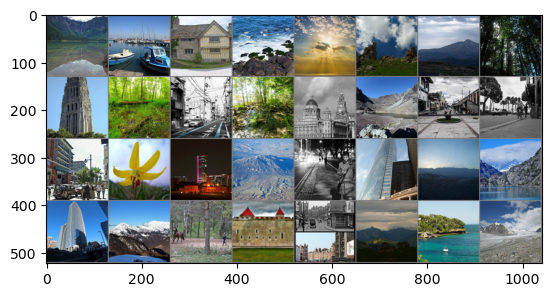

In [5]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

## Data Augmentation Techniques


In [6]:
# Define augmented transformations
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# Apply the augmented transformations to the training dataset
augmented_train_dataset = ImageFolder(root=os.path.join(data_dir, 'seg_train/seg_train'), transform=augmented_transform)

# Create a data loader for the augmented dataset
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)

## Creating Custom Data Loaders

In [8]:
# Function to create data loaders
def create_data_loaders(data_dir, batch_size=32, augmented=False):
    if augmented:
        transform = augmented_transform
    else:
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    dataset = ImageFolder(root=data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [9]:
# Create data loaders for the original and augmented datasets
train_loader, val_loader = create_data_loaders(os.path.join(data_dir, 'seg_train/seg_train'), augmented=False)
augmented_train_loader, _ = create_data_loaders(os.path.join(data_dir, 'seg_train/seg_train'), augmented=True)

## Visualizing Augmented Data

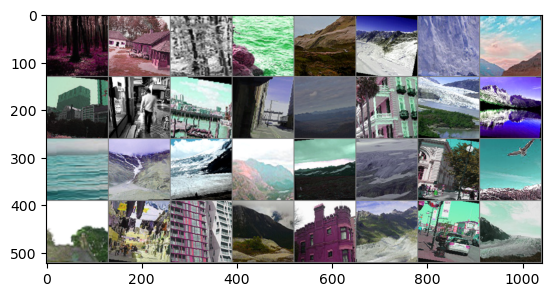

    1     0     1     4


In [10]:
# Function to visualize augmented images
def visualize_augmented_data(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    
    # Show images
    imshow(torchvision.utils.make_grid(images))
    # Print labels
    print(' '.join('%5s' % labels[j].item() for j in range(4)))

# Visualize augmented training data
visualize_augmented_data(augmented_train_loader)


## Checking for gpu availability

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Defining the model

In [14]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Flattened size = 64 * 32 * 32
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model (Intel dataset has 6 classes)
num_classes = len(train_dataset.dataset.classes)
model = CNNModel(num_classes).to(device)

## Define Loss Function and Optimizer

In [15]:
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adaptive learning rate optimizer

## Training the Model


In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update weights

            # Track accuracy and loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Validate after each epoch
        validate_model(model, val_loader)

## Validation Function

In [17]:
def validate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f'Validation Accuracy: {val_acc:.2f}%')

## Train the model

In [18]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:49<00:00,  3.22it/s]


Epoch [1/10], Loss: 1.1423, Accuracy: 55.78%
Validation Accuracy: 67.83%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:18<00:00,  4.48it/s]


Epoch [2/10], Loss: 0.7442, Accuracy: 72.01%
Validation Accuracy: 73.78%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:22<00:00,  4.25it/s]


Epoch [3/10], Loss: 0.5558, Accuracy: 79.52%
Validation Accuracy: 77.73%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:22<00:00,  4.27it/s]


Epoch [4/10], Loss: 0.3830, Accuracy: 86.37%
Validation Accuracy: 78.13%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:22<00:00,  4.26it/s]


Epoch [5/10], Loss: 0.2571, Accuracy: 90.97%
Validation Accuracy: 77.56%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:22<00:00,  4.26it/s]


Epoch [6/10], Loss: 0.1534, Accuracy: 94.53%
Validation Accuracy: 75.63%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:19<00:00,  4.44it/s]


Epoch [7/10], Loss: 0.0826, Accuracy: 97.51%
Validation Accuracy: 77.02%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:19<00:00,  4.43it/s]


Epoch [8/10], Loss: 0.0743, Accuracy: 97.58%
Validation Accuracy: 77.27%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:18<00:00,  4.49it/s]


Epoch [9/10], Loss: 0.0448, Accuracy: 98.74%
Validation Accuracy: 75.70%


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [01:19<00:00,  4.44it/s]


Epoch [10/10], Loss: 0.0469, Accuracy: 98.56%
Validation Accuracy: 75.67%


## Save the model

In [19]:
torch.save(model.state_dict(), 'intel_img_aug.pth')
print("Model saved as intel_img_aug.pth")

Model saved as intel_img_aug.pth
